## Install R Packages 

In [ ]:
# if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
# BiocManager::install(c("harmony"))
# BiocManager::install(c("glmGamPoi"))
# BiocManager::install('limma')
# install.packages("Seurat")
# install.packages("sctransform")
# install.packages('hdf5r')
# install.packages('devtools')
# devtools::install_github('immunogenomics/presto')

## Import R Packages 

In [4]:
# Library import

library(Seurat)
library(ggplot2)
library(sctransform)
library(harmony)
library(patchwork)
library(dplyr)
library(magrittr)

library(future)
plan("multicore", workers = 10)
options(future.globals.maxSize = 12000 * 1024^2)
future.seed=TRUE 

set.seed(1)

## Import Visium Data

In [6]:
data_dir <- './'
list.files(data_dir) # Should show filtered_feature_bc_matrix.h5
Visium_1 <- Load10X_Spatial(data.dir = data_dir)

[1] "cloupe.cloupe"                 "filtered_feature_bc_matrix.h5"
[3] "spatial"                       "Spatial.h5ad"                 
[5] "V12Y31-123_C1.svs"             "V12Y31-123_C1.tif"            
[7] "Visium Pipe.ipynb"             "web_summary.html"

## QC Visium Data

Warning message:
“Default search for "data" layer in "Spatial" assay yielded no results; utilizing "counts" layer instead.”


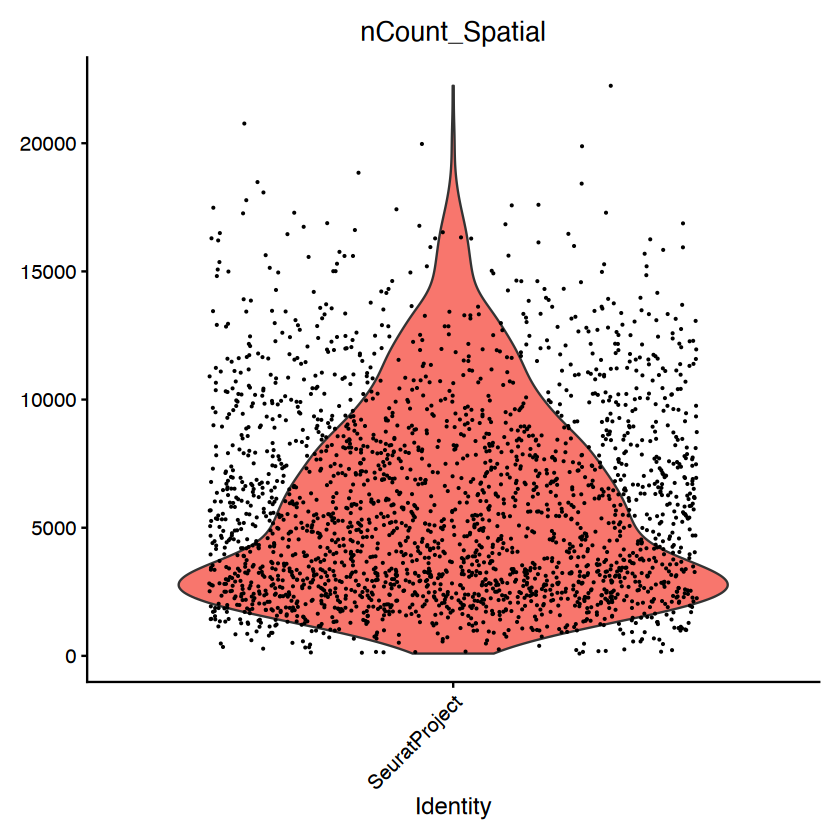

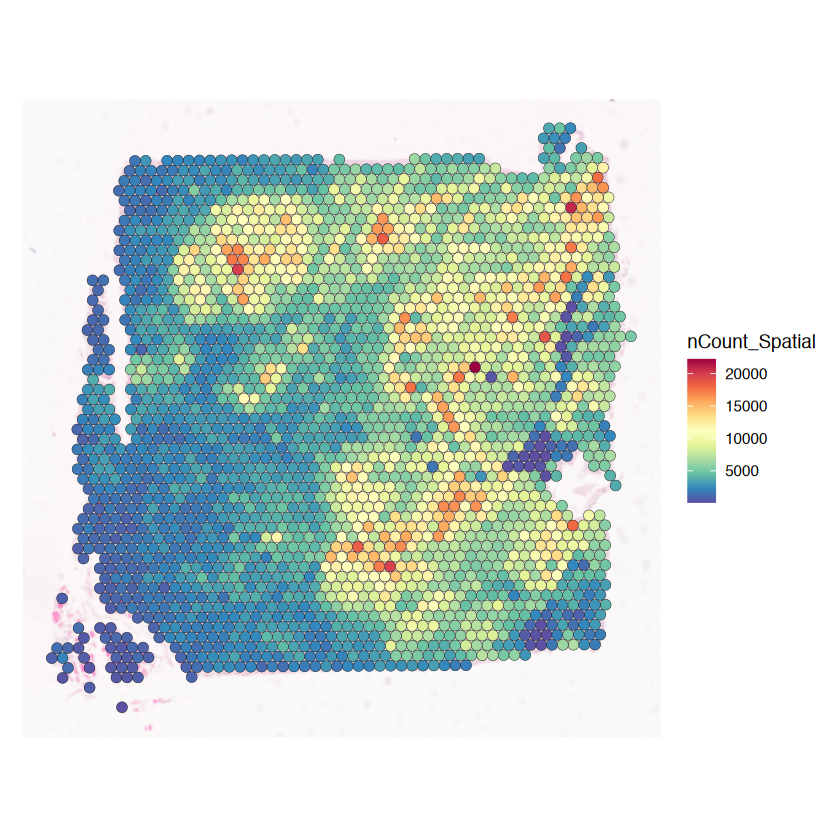

In [7]:
plot1 <- VlnPlot(Visium, features = "nCount_Spatial", pt.size = 0.1) + NoLegend()
plot2 <- SpatialFeaturePlot(Visium, features = "nCount_Spatial") + theme(legend.position = "right")
plot1
plot2

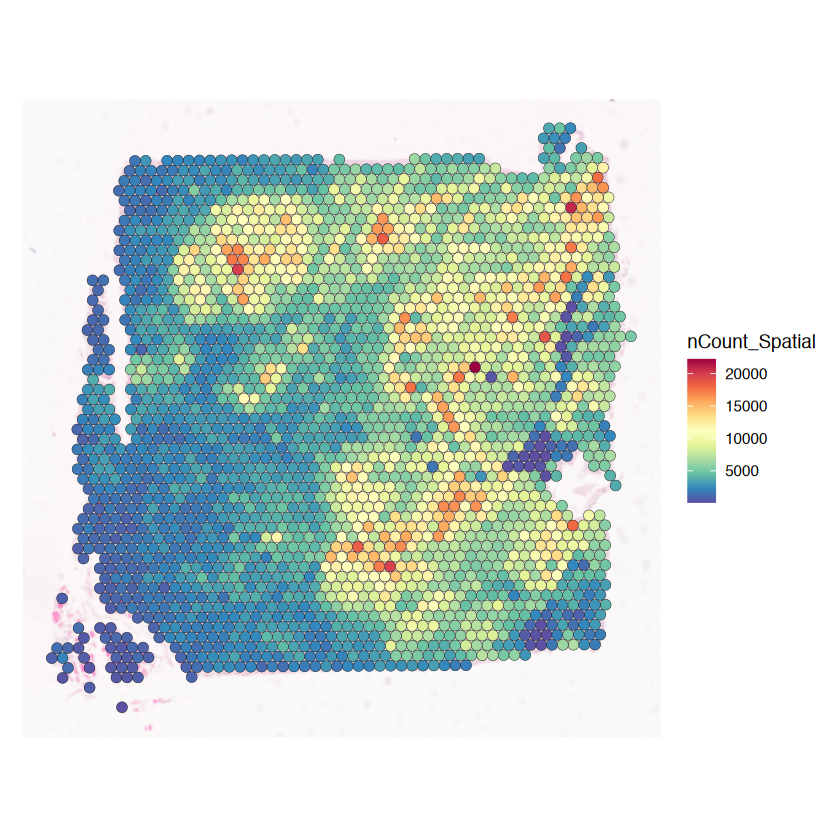

In [8]:
Visium_1_QC <- subset(Visium_1,  nCount_Spatial > 0)
SpatialFeaturePlot(Visium_1_QC, features = "nCount_Spatial") + theme(legend.position = "right")

## Data Normalization

#### SCTransform 

In [11]:
Visium <- SCTransform(Visium, assay = "Spatial", verbose = TRUE)
Visium

Running SCTransform on assay: Spatial

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 14341 by 2423

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2423 cells

Found 258 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 14341 genes

Computing corrected count matrix for 14341 genes

Calculating gene attributes

Wall clock passed: Time difference of 20.06387 secs

Determine variable features

Centering data matrix

Set default assay to SCT



An object of class Seurat 
32284 features across 2423 samples within 2 assays 
Active assay: SCT (14341 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: Spatial
 1 image present: slice1

## STdeconvolve 

In [451]:
# if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
# BiocManager::install(c("STdeconvolve"))

In [448]:
library(parallel)
library(STdeconvolve)

In [452]:
DefaultAssay(Visium) <- 'SCT'
counts <- as.matrix(GetAssayData(object = Visium, assay = 'Spatial', slot = "counts"), sparse = TRUE)
pos <- GetTissueCoordinates(Visium)
colnames(pos) <- c("x", "y")

#Choose 1000 top variable genes for further cell-type deconvolution
corpus <- restrictCorpus(counts, removeAbove=1.0, removeBelow = 0.05)
head(corpus)

Загрузка требуемого пакета: topicmodels

Warning message:
“пакет ‘topicmodels’ был собран под R версии 4.3.3”
Time to fit LDA models was 4.23 mins

Computing perplexity for each fitted model...

Time to compute perplexities was 0.18 mins

Getting predicted cell-types at low proportions...

Time to compute cell-types at low proportions was 0 mins

Plotting...

Warning message in ggplot2::geom_point(ggplot2::aes(y = rareCtsAdj, x = K), col = "blue", :
“Ignoring unknown parameters: `linewidth`”
Warning message in ggplot2::geom_point(ggplot2::aes(y = perplexAdj, x = K), col = "red", :
“Ignoring unknown parameters: `linewidth`”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'LDA models with α > 1 shaded' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'LDA models with α > 1 shaded' в 'mbcsToSbcs': точка заменена на <b1>”
Warning message in grid

$models
$models$`4`
A LDA_VEM topic model with 4 topics.

$models$`5`
A LDA_VEM topic model with 5 topics.

$models$`6`
A LDA_VEM topic model with 6 topics.

$models$`7`
A LDA_VEM topic model with 7 topics.

$models$`8`
A LDA_VEM topic model with 8 topics.

$models$`9`
A LDA_VEM topic model with 9 topics.

$models$`10`
A LDA_VEM topic model with 10 topics.

$models$`11`
A LDA_VEM topic model with 11 topics.

$models$`12`
A LDA_VEM topic model with 12 topics.


$kneedOptK
[1] 5

$minOptK
[1] 12

$ctPropOptK
[1] 9

$numRare
[1] 0 0 0 1 3 2 3 3 5

$perplexities
[1] 286.9857 279.0592 275.9395 274.3968 272.7281 273.8739 273.3849 273.3010
[9] 272.2349

$fitCorpus
A 2423x943 simple triplet matrix.

$testCorpus
A 2423x943 simple triplet matrix.


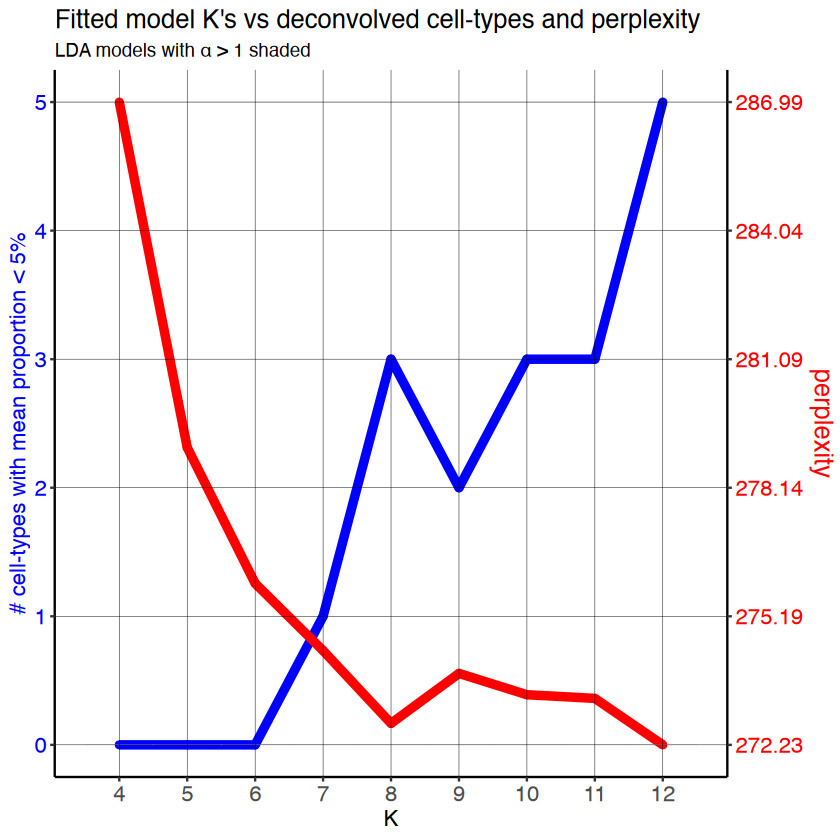

In [450]:
#corpus <- counts[which(rownames(counts)%in%immune_genes),]

#Fit LDA models to the data
ldas <- fitLDA(t(as.matrix(corpus)),ncores = detectCores(),seq(4,12,1))
ldas

In [469]:
optLDA <- optimalModel(models = ldas, opt = 8)
results <- getBetaTheta(optLDA, perc.filt = 0.05, betaScale = 1000)
deconProp <- results$theta
deconGexp <- results$beta

Filtering out cell-types in pixels that contribute less than 0.05 of the pixel proportion.




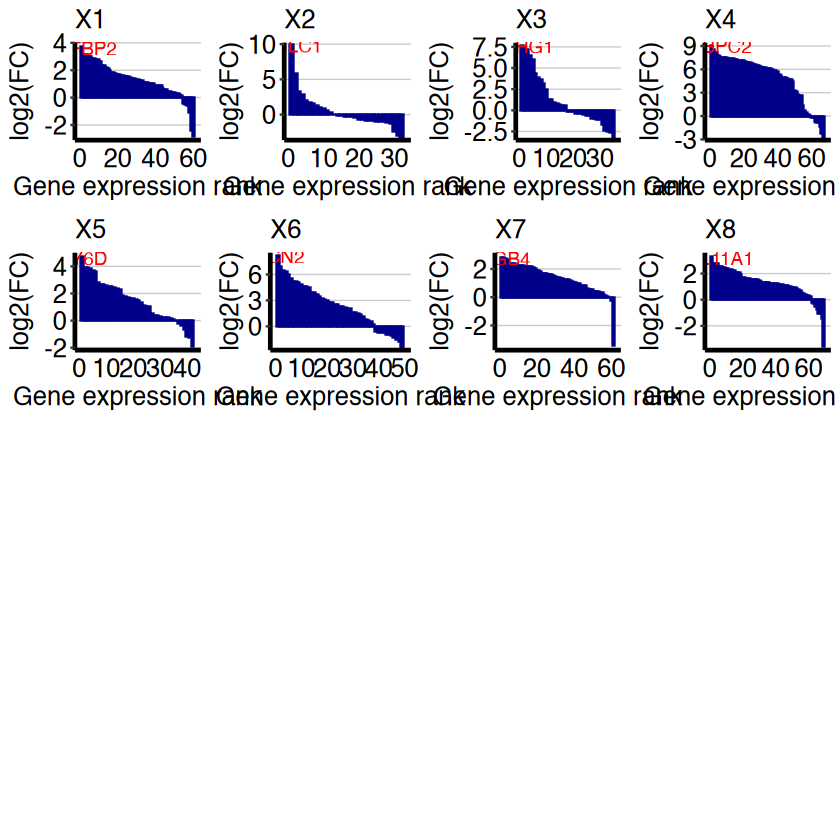

In [470]:
ps <- lapply(colnames(deconProp), function(celltype) {
  
  celltype <- as.numeric(celltype)
  ## highly expressed in cell-type of interest
  highgexp <- names(which(deconGexp[celltype,] > 3))
  ## high log2(fold-change) compared to other deconvolved cell-types
  log2fc <- sort(log2(deconGexp[celltype,highgexp]/colMeans(deconGexp[-celltype,highgexp])), decreasing=TRUE)
  markers <- names(log2fc)[1] ## label just the top gene
  markers
  
  # -----------------------------------------------------
  ## visualize the transcriptional profile
  dat <- data.frame(values = as.vector(log2fc), genes = names(log2fc), order = seq(length(log2fc)))
  # Hide all of the text labels.
  dat$selectedLabels <- ""
  dat$selectedLabels[1] <- markers
  
  plt <- ggplot2::ggplot(data = dat) +
    ggplot2::geom_col(ggplot2::aes(x = order, y = values,
                                   fill = factor(selectedLabels == ""),
                                   color = factor(selectedLabels == "")), width = 1) +
    
    ggplot2::scale_fill_manual(values = c("darkblue",
                                          "darkblue"
                                          )) +
    ggplot2::scale_color_manual(values = c("darkblue",
                                          "darkblue"
                                          )) +
    
    ggplot2::scale_y_continuous(expand = c(0, 0), limits = c(min(log2fc) - 0.3, max(log2fc) + 0.3)) +
    # ggplot2::scale_x_continuous(expand = c(0, 0), limits = c(-2, NA)) +
    
    ggplot2::labs(title = paste0("X", celltype),
                  x = "Gene expression rank",
                  y = "log2(FC)") +
    
    ## placement of gene symbol labels of top genes
    ggplot2::geom_text(ggplot2::aes(x = order+1, y = values-0.1, label = selectedLabels), color = "red") +
    
    ggplot2::theme_classic() +
    ggplot2::theme(axis.text.x = ggplot2::element_text(size=15, color = "black"),
                   axis.text.y = ggplot2::element_text(size=15, color = "black"),
                   axis.title.y = ggplot2::element_text(size=15, color = "black"),
                   axis.title.x = ggplot2::element_text(size=15, color = "black"),
                   axis.ticks.x = ggplot2::element_blank(),
                   plot.title = ggplot2::element_text(size=15),
                   legend.text = ggplot2::element_text(size = 15, colour = "black"),
                   legend.title = ggplot2::element_text(size = 15, colour = "black", angle = 90),
                   panel.background = ggplot2::element_blank(),
                   plot.background = ggplot2::element_blank(),
                   panel.grid.major.y = ggplot2::element_line(size = 0.3, colour = "gray80"),
                   axis.line = ggplot2::element_line(size = 1, colour = "black"),
                   legend.position="none"
                   )
  plt
})
gridExtra::grid.arrange(
  grobs = ps,
  layout_matrix = rbind(c(1, 2, 3, 4),
                        c(5, 6, 7, 8),
                        c(9, 10, 11, 12),
                        c(13, 14, 15, 16))
)

In [475]:
highly_expressed_genes <- lapply(colnames(deconProp), function(celltype) {
  celltype <- as.numeric(celltype)
  ## highly expressed in cell-type of interest
  highgexp <- names(which(deconGexp[celltype,] > 3))
  ## high log2(fold-change) compared to other deconvolved cell-types
  log2fc <- sort(log2(deconGexp[celltype,highgexp]/colMeans(deconGexp[-celltype,highgexp])), decreasing=TRUE)
  
  ## return a list with cell type and highly expressed genes
  list(cell_type = celltype, highly_expressed_genes = highgexp)
})

highly_expressed_genes

[[1]]
[[1]]$cell_type
[1] 1

[[1]]$highly_expressed_genes
 [1] "ENO1"     "CTNNBIP1" "SH3BGRL3" "IFI6"     "SLC2A1"   "CLCA2"   
 [7] "S100A11"  "S100A9"   "S100A8"   "S100A2"   "LAMC2"    "IVNS1ABP"
[13] "PKP1"     "LAMB3"    "ITGA6"    "IGFBP2"   "COL7A1"   "SPON2"   
[19] "CXCL14"   "TGFBI"    "DSP"      "DDR1"     "HSPA1B"   "CDKN1A"  
[25] "DST"      "GJA1"     "PERP"     "GPNMB"    "IGFBP3"   "HSPB1"   
[31] "FABP5"    "NDRG1"    "PLEC"     "BICD2"    "TXN"      "COL17A1" 
[37] "HTRA1"    "CD151"    "CD44"     "SLC3A2"   "GSTP1"    "MMP10"   
[43] "MMP1"     "MMP3"     "TRIM29"   "SLC38A2"  "KRT6B"    "KRT5"    
[49] "GJB2"     "IFI27"    "IGF1R"    "KRT10"    "KRT14"    "KRT16"   
[55] "JUP"      "ITGA3"    "FXYD3"    "MMP9"     "APP"      "CSTB"    


[[2]]
[[2]]$cell_type
[1] 2

[[2]]$highly_expressed_genes
 [1] "ISG15"   "ENO1"    "IFI6"    "F3"      "S100A11" "S100A8"  "S100A2" 
 [8] "IGKC"    "IGKV4-1" "CXCL9"   "CXCL10"  "TGFBI"   "TAP1"    "HSPB1"  
[15] "PLEC"    "TXN"     "IFIT3"   "COL17A1" "CD44"    "GSTP1"   "MMP1"   
[22] "KRT5"    "LYZ"     "IFI27"   "WARS"    "IGHG2"   "KRT14"   "KRT16"  
[29] "CST1"    "APP"     "IGLC1"   "TIMP1"  


[[3]]
[[3]]$cell_type
[1] 3

[[3]]$highly_expressed_genes
 [1] "ISG15"   "ENO1"    "IFI6"    "COL11A1" "S100A11" "S100A9"  "S100A8" 
 [8] "IGKC"    "IGKV4-1" "LRRC15"  "JCHAIN"  "TGFBI"   "GJA1"    "HSPB1"  
[15] "PLEC"    "HTRA1"   "GSTP1"   "MMP1"    "KRT5"    "LYZ"     "IFI27"  
[22] "IGHG2"   "IGHA1"   "IGHG1"   "IGHG3"   "IGHM"    "IGHJ6"   "KRT14"  
[29] "KRT16"   "APOE"    "CST1"    "APP"     "IGLV3-1" "MMP11"   "TIMP1"  


[[4]]
[[4]]$cell_type
[1] 4

[[4]]$highly_expressed_genes
 [1] "PLA2G2A" "S100A11" "S100A1"  "TNNI1"   "CYB5R1"  "MYBPH"   "ACTN2"  
 [8] "GNLY"    "ANKRD23" "BIN1"    "NEB"     "KLHL41"  "TTN"     "MYL1"   
[15] "DES"     "TNNC1"   "MUSTN1"  "APOD"    "SYNPO2"  "C4orf3"  "CMYA5"  
[22] "CXCL14"  "HSPA1B"  "TNXB"    "PI16"    "DST"     "TRDN"    "AQP1"   
[29] "HSPB1"   "FLNC"    "CLU"     "PLEC"    "ANKRD1"  "TNNT3"   "CSRP3"  
[36] "GSTP1"   "MMP1"    "SLN"     "CRYAB"   "NR4A1"   "STAC3"   "MYF6"   
[43] "MYBPC1"  "NDRG2"   "AKAP6"   "SPTB"    "ACTC1"   "MYLPF"   "COX6A2" 
[50] "RRAD"    "ENO3"    "MYH1"    "MYH2"    "TCAP"    "KRT14"   "HSPB6"  
[57] "RYR1"    "CKM"     "MYBPC2"  "TNNT1"   "CHGB"    "TNNC2"   "EEF1A2" 
[64] "APP"     "MB"      "SMPX"    "TIMP1"  


[[5]]
[[5]]$cell_type
[1] 5

[[5]]$highly_expressed_genes
 [1] "ISG15"   "IFI6"    "S100A11" "IVL"     "SPRR1B"  "SPRR2D"  "SPRR2A" 
 [8] "S100A9"  "S100A8"  "S100A7A" "S100A7"  "S100A2"  "S100A14" "CRABP2" 
[15] "CSTA"    "TM4SF1"  "C4orf3"  "DSP"     "GJA1"    "PERP"    "HSPB1"  
[22] "FABP5"   "LY6D"    "AQP3"    "CD44"    "GSTP1"   "MMP1"    "TRIM29" 
[29] "KRT6B"   "KRT5"    "GJB2"    "IFI27"   "KRT14"   "KRT16"   "JUP"    
[36] "KRTDAP"  "SBSN"    "CNFN"    "KLK10"   "PI3"     "SLPI"    "CSTB"   


[[6]]
[[6]]$cell_type
[1] 6

[[6]]$highly_expressed_genes
 [1] "ISG15"   "IFI6"    "SERINC2" "TACSTD2" "S100A11" "CRCT1"   "LCE3E"  
 [8] "LCE3D"   "IVL"     "SPRR1B"  "SPRR2D"  "SPRR2A"  "SPRR2G"  "S100A9" 
[15] "S100A8"  "S100A7A" "S100A7"  "S100A2"  "CRABP2"  "ATP1B1"  "CSTA"   
[22] "TM4SF1"  "S100P"   "C4orf3"  "CDSN"    "HSPB1"   "LCN2"    "CST6"   
[29] "GSTP1"   "MMP1"    "KRT5"    "GJB2"    "NDRG2"   "ERO1A"   "IFI27"  
[36] "KRT16"   "KRTDAP"  "SBSN"    "CNFN"    "KLK5"    "KLK6"    "KLK7"   
[43] "KLK10"   "KLK11"   "PI3"     "SLPI"    "SDC4"    "APP"     "CSTB"   


[[7]]
[[7]]$cell_type
[1] 7

[[7]]$highly_expressed_genes
 [1] "ISG15"    "AGRN"     "ENO1"     "IFI6"     "SERINC2"  "SLC2A1"  
 [7] "F3"       "S100A11"  "S100A2"   "LAMC2"    "LAMB3"    "ITGA6"   
[13] "TUBA4A"   "COL7A1"   "TP63"     "SPON2"    "CXCL14"   "TGFBI"   
[19] "DSP"      "HSPA1B"   "GLO1"     "DST"      "GJA1"     "PERP"    
[25] "FSCN1"    "HSPB1"    "CAV2"     "CAV1"     "PLEC"     "TXN"     
[31] "PSMB7"    "COL17A1"  "DKK3"     "CD44"     "SLC3A2"   "RHOD"    
[37] "GSTP1"    "PRSS23"   "MMP

In [486]:
data <- do.call(rbind, lapply(highly_expressed_genes, function(x) {
  data.frame(cell_type = x$cell_type, highly_expressed_genes = x$highly_expressed_genes)
}))
head(data)

cell_type highly_expressed_genes
1 1         ENO1                  
2 1         CTNNBIP1              
3 1         SH3BGRL3              
4 1         IFI6                  
5 1         SLC2A1                
6 1         CLCA2

## EnrichR

In [483]:
install.packages('devtools')
library(devtools)
install_github("wjawaid/enrichR")
install.packages('data.table')


Скачанные бинарные пакеты находятся в
	/var/folders/lk/54m90rgj1fqg895lxsgx1l180000gn/T//RtmpG0mi0I/downloaded_packages


ERROR: Error in install_github("wjawaid/enrichR"): не могу найти функцию "install_github"


In [487]:
library(data.table)
library(enrichR)

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!



In [488]:
# enrichR https://github.com/wjawaid/enrichR
listEnrichrSites()
setEnrichrSite("Enrichr")
dbs <- listEnrichrDbs()
dbs

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



geneCoverage genesPerTerm libraryName                                
1   13362         275         Genome_Browser_PWMs                        
2   27884        1284         TRANSFAC_and_JASPAR_PWMs                   
3    6002          77         Transcription_Factor_PPIs                  
4   47172        1370         ChEA_2013                                  
5   47107         509         Drug_Perturbations_from_GEO_2014           
6   21493        3713         ENCODE_TF_ChIP-seq_2014                    
7    1295          18         BioCarta_2013                              
8    3185          73         Reactome_2013                              
9    2854          34         WikiPathways_2013                          
10  15057         300         Disease_Signatures_from_GEO_up_2014        
11   4128          48         KEGG_2013                                  
12  34061         641         TF-LOF_Expression_from_GEO                 
13   7504         155         TargetScan_microRNA                        
14  16399         247         PPI_Hub_Proteins                           
15  12753          57         GO_Molecular_Function_2015                 
16  23726         127         GeneSigDB                                  
17  32740          85         Chromosome_Location                        
18  13373         258         Human_Gene_Atlas                           
19  19270         388         Mouse_Gene_Atlas                           
20  13236          82         GO_Cellular_Component_2015                 
21  14264          58         GO_Biological_Process_2015                 
22   3096          31         Human_Phenotype_Ontology                   
23  22288        4368         Epigenomics_Roadmap_HM_ChIP-seq            
24   4533          37         KEA_2013                                   
25  10231         158         NURSA_Human_Endogenous_Complexome          
26   2741           5         CORUM                                      
27   5655         342         SILAC_Phosphoproteomics                    
28  10406         715         MGI_Mammalian_Phenotype_Level_3            
29  10493         200         MGI_Mammalian_Phenotype_Level_4            
30  11251         100         Old_CMAP_up                                
⋮   ⋮            ⋮            ⋮                                          
198 13525        175          Diabetes_Perturbations_GEO_2022            
199  9525        245          LINCS_L1000_Chem_Pert_Consensus_Sigs       
200  9440        245          LINCS_L1000_CRISPR_KO_Consensus_Sigs       
201  3857         80          Tabula_Muris                               
202 10489         61          Reactome_2022                              
203  1198         23          SynGO_2022                                 
204  1882         47          GlyGen_Glycosylated_Proteins_2022          
205  1552         16          IDG_Drug_Targets_2022                      
206  6713         68          KOMP2_Mouse_Phenotypes_2022                
207   936         15          Metabolomics_Workbench_Metabolites_2022    
208  8220        146          Proteomics_Drug_Atlas_2023                 
209  9021        793          The_Kinase_Library_2023                    
210  8076         96          GTEx_Tissues_V8_2023                       
211 14698         33          GO_Biological_Process_2023                 
212 10972         85          GO_Cellular_Component_2023                 
213 12126         38          GO_Molecular_Function_2023                 
214 13662         12          PFOCR_Pathways_2023                        
215 18290         34          GWAS_Catalog_2023                          
216 12081         50          GeDiPNet_2023                              
217 12853        485          MAGNET_2023                                
218  3712          9          Azimuth_2023                               
219 19178        218          Rummagene_kinases                          
220 1943

In [489]:
# Select DB
dbs <- c("GO_Biological_Process_2023")

In [490]:
# Topic 1
enriched_1 <- enrichr(c(setDT(data)[cell_type == 1, highly_expressed_genes]), dbs) 
enriched_1

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                                  Term
1                                                                Basal Cell Lung Human
2                                                   Basal Cell Airway Epithelium Human
3                                                              Neutrophil Plasma Human
4                                                             Basal Cell Bladder Human
5                                                     Cancer Stem Cell Undefined Human
6                                                              Keratinocyte Skin Human
7                                                      Epithelial Cell Undefined Human
8                                                              Neutrophil Breast Mouse
9                                                             Basal Cell Trachea Mouse
10                                                               Neutrophil Lung Mouse
11                                             Plasmacytoid Dendritic Cell Blood Human
12                                                    Epithelial Cell Bronchiole Human
13                                                              Neutrophil Liver Mouse
14                                                     Epithelial Cell Esophagus Human
15                                                          Epithelial Cell Skin Mouse
16                                                Luminal Progenitor Cell Breast Human
17                                           Classical Monocyte Peripheral Blood Human
18                                         Astrocyte Embryonic Prefrontal Cortex Human
19                                                        Macrophage Nasopharynx Human
20                                                                Osteocyte Bone Human
21                                                        Neutrophil Bone Marrow Mouse
22                                Fibrocartilage Chondrocyte Articular Cartilage Human
23                                       Schwalie Et al.Nature.G3 Adipose Tissue Mouse
24                                                         Monocyte Fetal Kidney Human
25                                                        Epithelial Cell Breast Human
26                                                          Epithelial Cell Skin Human
27                                                     Cancer Stem Cell Prostate Human
28                                          Mesenchymal Stromal Cell Bone Marrow Human
29                                                          Epithelial Cell Lung Mouse
30                                                      Sertoli Cell Fetal Gonad Human
31                                                             Neutrophil Kidney Human
32                                  Myeloid Derived Suppressor Cell (MDSC) Liver Human
33                                                      Basal Cell Mammary Gland Mouse
34                                                  Basal Progenitor Cell Breast Human
35                                                      Cancer Stem Cell Stomach Human
36                                                             Stem Cell Bladder Human
37                                                           Epidermal Cell Skin Human
38                                                  CD4+ T Cell Peripheral Blood Human
39                                                          Neutrophil Undefined Human
40                                                               Basal Cell Skin Human
41                                              Suprabasal Outer Layer Cell Skin Mouse
42                                                 Granulocytic Neutrophil Blood Mouse
43                                                             Monocyte Pancreas Human
44                                                           Basal Cell Prostate Human
45                                                       Cancer Stem

In [491]:
# Topic 2
enriched_2 <- enrichr(c(setDT(data)[cell_type == 2, highly_expressed_genes]), dbs) 
enriched_2

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                                  Term
1                                                                Basal Cell Lung Human
2                                                             M1 Macrophage Skin Human
3                                            Classical Monocyte Peripheral Blood Human
4                                                   Exhausted CD8+ T Cell Breast Human
5                                                             Basal Cell Bladder Human
6                                                              Keratinocyte Skin Human
7                                                   Basal Cell Airway Epithelium Human
8                                                         Neutrophil Bone Marrow Mouse
9                                                        Plasma Cell Nasopharynx Human
10                                                                 B Cell Spleen Mouse
11                                                        Neutrophil Bone Marrow Human
12                                                              Macrophage Brain Human
13                                                      Basal Cell Mammary Gland Mouse
14                                                             Stem Cell Bladder Human
15                                                    Cancer Stem Cell Undefined Human
16                                Fibrocartilage Chondrocyte Articular Cartilage Human
17                                                                 Monocyte Lung Human
18                                                               Monocyte Rectum Human
19                                              Suprabasal Outer Layer Cell Skin Mouse
20                                                               Basal Cell Skin Human
21                                                        Macrophage Nasopharynx Human
22                                                       Limbal Stem Cell Cornea Human
23                                                          Myeloid Cell Stomach Human
24                                                            CD8+ T Cell Breast Human
25                                                                Monocyte Blood Human
26                                                     Epithelial Cell Esophagus Human
27                                                              Monocyte Decidua Human
28                                                             Basal Cell Breast Human
29                                                      Cancer Stem Cell Bladder Human
30                                                             Macrophage Rectum Human
31                                                               Monocyte Kidney Human
32                                                               Monocyte Spleen Human
33                                                             Neutrophil Plasma Human
34                                                          Epithelial Cell Skin Mouse
35                                                Luminal Progenitor Cell Breast Human
36                                              CD1C-CD141- Dendritic Cell Blood Human
37                                                   Astrocyte Entorhinal Cortex Human
38                                              Astrocyte Superior Frontal Gyrus Human
39                                                               Monocyte Breast Human
40                                                         Monocyte Fetal Kidney Human
41                                       Idiopathic Pulmonary Fibrosis Cell Lung Human
42                                                   Macrophage Peripheral Blood Human
43                                                  Liver Bud Hepatic Cell Liver Human
44                                                          Monocyte Nasopharynx Human
45                                                                 M

In [492]:
# Topic 3
enriched_3 <- enrichr(c(setDT(data)[cell_type == 3, highly_expressed_genes]), dbs) 
enriched_3

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                                  Term
1                                            Classical Monocyte Peripheral Blood Human
2                                                                Basal Cell Lung Human
3                                                        Plasma Cell Nasopharynx Human
4                                                           Myeloid Cell Stomach Human
5                                                                Monocyte Kidney Human
6                                                                Monocyte Spleen Human
7                                                              Neutrophil Plasma Human
8                                                                  Monocyte Lung Human
9                                                             Basal Cell Bladder Human
10                                Fibrocartilage Chondrocyte Articular Cartilage Human
11                                                               Monocyte Breast Human
12                                                          Monocyte Nasopharynx Human
13                                                                 Monocyte Skin Human
14                                                        Neutrophil Bone Marrow Mouse
15                                                        Epithelial Cell Breast Human
16                                                  Exhausted CD8+ T Cell Breast Human
17                                                            Plasma Cell Kidney Human
18                                               Dendritic Cell Peripheral Blood Human
19                                                              Macrophage Brain Human
20                                         Astrocyte Embryonic Prefrontal Cortex Human
21                                  Myeloid Derived Suppressor Cell (MDSC) Liver Human
22                                                      Basal Cell Mammary Gland Mouse
23                                               CD14+ Monocyte Peripheral Blood Human
24                                                             Neutrophil Breast Mouse
25                                                    Cancer Stem Cell Undefined Human
26                                                               Monocyte Rectum Human
27                                              Suprabasal Outer Layer Cell Skin Mouse
28                                                               Basal Cell Skin Human
29                                                 Granulocytic Neutrophil Blood Mouse
30                                                               Neutrophil Lung Mouse
31                                                             Monocyte Pancreas Human
32                                                       Limbal Stem Cell Cornea Human
33                                                            M1 Macrophage Skin Human
34  Polymorphonuclear Myeloid-Derived suppressor(PMN-MDSC) Cell Peripheral Blood Human
35                                                        Macrophage Nasopharynx Human
36                                                     Epithelial Cell Esophagus Human
37                                                              Monocyte Decidua Human
38                                                             Basal Cell Breast Human
39                                         Type 3 Dendritic Cell (DC3) Undefined Human
40                                                              Neutrophil Liver Mouse
41                                                             Macrophage Rectum Human
42                                              Quiescent Neural Stem Cell Brain Mouse
43                                                  CD1C+ B Dendritic Cell Blood Human
44                                     Monocyte-derived Dendritic Cell Undefined Human
45                                            Adenocarcinoma Stem-Li

In [493]:
# Topic 4
enriched_4 <- enrichr(c(setDT(data)[cell_type == 4, highly_expressed_genes]), dbs) 
enriched_4

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                            Term
1                                                       Muscle Cell Muscle Mouse
2                                                      Cardiomyocyte Heart Mouse
3                                                          Fibroblast Skin Human
4                                                     Cardiomyocyte Embryo Mouse
5                                     Contractile Smooth Muscle Cell Aorta Mouse
6                                                  Axin2-Palpha+ Cell Lung Mouse
7                                    Astrocyte Embryonic Prefrontal Cortex Human
8                                                            Myocyte Aorta Mouse
9                                                  Smooth Muscle Cell Lung Mouse
10                                  Tumor Associated Macrophage (TAM) Skin Mouse
11                                                      Myofibroblast Lung Mouse
12                                                       Myocyte Undefined Human
13                                                   P53-like Cell Bladder Human
14                                                 Myofibroblast Undefined Human
15                                 Schwalie Et al.Nature.G1 Adipose Tissue Mouse
16                                 Schwalie Et al.Nature.P3 Adipose Tissue Mouse
17                                                   Mesangial Cell Kidney Mouse
18                                        Luminal Progenitor Cell Prostate Mouse
19                                                        Axin2+ Cell Lung Mouse
20                                            Basal Cell Airway Epithelium Human
21                                          Stage I Neutrophil Bone Marrow Mouse
22                                      Rheaume Et al.Nat Commun.33 Retina Mouse
23                                                  Stromal Cell Undefined Human
24                                                   CCK Basket Cell Brain Mouse
25                                                     Cardiomyocyte Heart Human
26                                                         Basal Cell Lung Human
27                                   T Follicular helper(Tfh) Cell Stomach Human
28                                                         Astrocyte Brain Human
29                                         Morula Cell (Blastomere) Embryo Mouse
30                                   Enteroendocrine Cell Intestinal Crypt Mouse
31                                    Type II Spiral Ganglion Neuron Brain Mouse
32                               Regulatory T (Treg) Cell Peripheral Blood Human
33                                                         Monocyte Spleen Mouse
34                                                         Astrocyte Brain Mouse
35                                       Monocyte-derived Macrophage Brain Mouse
36                                                    Mural Cell Undefined Mouse
37                                               Myoepithelial Cell Breast Human
38                                       Myoepithelial Cell Lacrimal Gland Mouse
39                                                Basal Cell Mammary Gland Mouse
40                                         CD14+ Monocyte Peripheral Blood Human
41                                                        Glial Cell Brain Human
42                                                        Glial Cell Brain Mouse
43                                                       Glial Cell Tongue Mouse
44                                       Natural Killer T(NKT) Cell Kidney Human
45                                                  CD8+ T Cell Epithelium Human
46                                             Neuroendocrine Cell Bladder Human
47                                                 Inhibitory Neuron Brain Mouse
48                                 Cancer-associated Fibroblast Colorectum Human
49            

In [494]:
# Topic 5
enriched_5 <- enrichr(c(setDT(data)[cell_type == 5, highly_expressed_genes]), dbs)
enriched_5

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                                  Term
1                                                                Basal Cell Lung Human
2                                                              Keratinocyte Skin Human
3                                                             Basal Cell Bladder Human
4                                                                Basal Cell Skin Human
5                                                     Epithelial Cell Bronchiole Human
6                                                      Epithelial Cell Esophagus Human
7                                                              Neutrophil Plasma Human
8                                            Classical Monocyte Peripheral Blood Human
9                                                 Luminal Progenitor Cell Breast Human
10                                                            Basal Cell Trachea Mouse
11                                                    Cancer Stem Cell Undefined Human
12                                                  Basal Cell Airway Epithelium Human
13                                                        Neutrophil Bone Marrow Mouse
14                                                        Epithelial Cell Breast Human
15                                                          Epithelial Cell Skin Human
16                                                  Exhausted CD8+ T Cell Breast Human
17                                                        Neutrophil Bone Marrow Human
18                                                        Endothelial Cell Ovary Human
19                                                             Neutrophil Kidney Human
20                                                          Neutrophil Undefined Human
21                                  Myeloid Derived Suppressor Cell (MDSC) Liver Human
22                                                      Basal Cell Mammary Gland Mouse
23                                                             Neutrophil Breast Mouse
24                                         Squamous-differentiation Cell Bladder Human
25                                                             Stem Cell Bladder Human
26                                              Suprabasal Outer Layer Cell Skin Mouse
27                                                 Granulocytic Neutrophil Blood Mouse
28                                                               Neutrophil Lung Mouse
29                                                 Pelvic Epithelial Cell Kidney Human
30                                                             Monocyte Pancreas Human
31                                                       Limbal Stem Cell Cornea Human
32                                                            M1 Macrophage Skin Human
33  Polymorphonuclear Myeloid-Derived suppressor(PMN-MDSC) Cell Peripheral Blood Human
34                                                     Epithelial Cell Undefined Human
35                                                          Myeloid Cell Stomach Human
36                                                             Basal Cell Breast Human
37                                         Type 3 Dendritic Cell (DC3) Undefined Human
38                                                      Cancer Stem Cell Bladder Human
39                                                              Neutrophil Liver Mouse
40                                                       Endothelial Cell Spleen Human
41                                                              Mural Cell Brain Mouse
42                                     Monocyte-derived Dendritic Cell Undefined Human
43                                            Adenocarcinoma Stem-Like Cell Lung Human
44                                                               Monocyte Kidney Human
45                                                               Mon

In [495]:
# Topic 6
enriched_6 <- enrichr(c(setDT(data)[cell_type == 6, highly_expressed_genes]), dbs)
enriched_6

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                                  Term
1                                                  Pelvic Epithelial Cell Kidney Human
2                                                                Basal Cell Lung Human
3                                                         Neutrophil Bone Marrow Mouse
4                                                  Granulocytic Neutrophil Blood Mouse
5                                                                Neutrophil Lung Mouse
6   Polymorphonuclear Myeloid-Derived suppressor(PMN-MDSC) Cell Peripheral Blood Human
7                                                              Neutrophil Kidney Human
8                                                              Neutrophil Plasma Human
9                                            Classical Monocyte Peripheral Blood Human
10                                                             Keratinocyte Skin Human
11                                                               Neutrophil Lung Human
12                                                  Exhausted CD8+ T Cell Breast Human
13                                                        Neutrophil Bone Marrow Human
14                                  Myeloid Derived Suppressor Cell (MDSC) Liver Human
15                                                        Urothelium Cell Kidney Human
16                                                             Neutrophil Breast Mouse
17                                         Squamous-differentiation Cell Bladder Human
18                                              Suprabasal Outer Layer Cell Skin Mouse
19                                                               Basal Cell Skin Human
20                                                            Basal Cell Trachea Mouse
21                                                             Neutrophil Kidney Mouse
22                                                             Monocyte Pancreas Human
23                                                           Basal Cell Prostate Human
24                                                            M1 Macrophage Skin Human
25                                                          Myeloid Cell Stomach Human
26                                         Type 3 Dendritic Cell (DC3) Undefined Human
27                                                              Neutrophil Liver Mouse
28                                                       Endothelial Cell Spleen Human
29                                     Monocyte-derived Dendritic Cell Undefined Human
30                                            Adenocarcinoma Stem-Like Cell Lung Human
31                                                               Monocyte Kidney Human
32                                                               Monocyte Spleen Human
33                                                            Myeloid Cell Colon Human
34                                                  CD1C+ B Dendritic Cell Blood Human
35                                                Luminal Progenitor Cell Breast Human
36                                              Luminal Progenitor Cell Prostate Mouse
37                                                        Epithelial Cell Breast Mouse
38                                                            Basal Cell Bladder Human
39                                                               Monocyte Breast Human
40                                                Stage I Neutrophil Bone Marrow Mouse
41                                                       Plasma Cell Nasopharynx Human
42                                           Secretory Progenitor Cell Esophagus Human
43                                                          Monocyte Nasopharynx Human
44                                                                 Monocyte Skin Human
45                                                  Basal Cell Airwa

In [496]:
# Topic 7
enriched_7 <- enrichr(c(setDT(data)[cell_type == 7, highly_expressed_genes]), dbs)
enriched_7

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                  Term Overlap
1                                   Basal Cell Airway Epithelium Human    9/18
2                                                Basal Cell Lung Human   10/99
3                                      Epithelial Cell Undefined Human    6/44
4                                           Epithelial Cell Lung Mouse   9/318
5                                            Basal Cell Prostate Human     3/7
6                                        Limbal Stem Cell Cornea Human     3/7
7                                     Cancer Stem Cell Undefined Human   6/110
8                 Fibrocartilage Chondrocyte Articular Cartilage Human   6/111
9                                      Epithelial Cell Esophagus Human     3/9
10                                          Epithelial Cell Skin Mouse    3/11
11                                Luminal Progenitor Cell Breast Human    3/11
12                            Mesenchymal Stromal Cell Undefined Human    4/37
13                                            Basal Cell Bladder Human    3/12
14                                      Sertoli Cell Fetal Gonad Human   9/449
15                       Idiopathic Pulmonary Fibrosis Cell Lung Human    3/14
16                                             Keratinocyte Skin Human    3/15
17                               Mesenchymal Stem Cell Undefined Human    4/60
18                                          Epithelial Cell Skin Human    3/22
19                                     Cancer Stem Cell Prostate Human    3/23
20                                  Exhausted CD8+ T Cell Breast Human    3/24
21                             Plasmacytoid Dendritic Cell Blood Human   7/338
22                         Astrocyte Embryonic Prefrontal Cortex Human   7/343
23                                      Basal Cell Mammary Gland Mouse     2/5
24                                  Basal Progenitor Cell Breast Human     2/5
25                                     Trophoblast Cell Placenta Human     2/5
26                                        Urothelium Cell Kidney Human     2/5
27                                      Cancer Stem Cell Stomach Human     2/5
28                                             Stem Cell Bladder Human     2/5
29                              Epithelial Cell Bronchial Vessel Human    3/31
30                                  CD4+ T Cell Peripheral Blood Human    3/31
31                                   Cytotoxic CD4+ T Cell Liver Human    4/85
32                              Suprabasal Outer Layer Cell Skin Mouse     2/6
33                                               Basal Cell Skin Human     2/6
34                   Migration Phase Fetal Germ Cell Fetal Gonad Human   5/165
35                                    Epithelial Cell Bronchiole Human     2/7
36                                       Cancer Stem Cell Uterus Human     2/7
37                                            Basal Cell Trachea Mouse    4/98
38                                 Hematopoietic Stem Cell Blood Human    3/40
39                                Regulatory T (Treg) Cell Liver Human   7/411
40                                     Epithelial Cell Undefined Mouse     2/9
41                                             Basal Cell Breast Human     2/9
42                                      Cancer Stem Cell Bladder Human     2/9
43                               Morula Cell (Blastomere) Embryo Human   4/108
44                                               Astrocyte Brain Human   5/204
45                                            Stem Cell Prostate Human    2/10
46                                             Stem Cell Stomach Human    2/10
47                                         Krt4/13+ Cell Trachea Mouse   4/124
48                                        Epithelial Cell Breast Mouse    2/12
49                                   Astrocyte Entorhinal Cortex Human    2/12
50                              A

In [497]:
# Topic 8
enriched_8 <- enrichr(c(setDT(data)[cell_type == 8, highly_expressed_genes]), dbs)
enriched_8

Uploading data to Enrichr... Done.
  Querying CellMarker_2024... Done.
Parsing results... Done.


$CellMarker_2024
                                                                   Term Overlap
1                                                 Basal Cell Lung Human   10/99
2                                  Regulatory T (Treg) Cell Liver Human  11/411
3                             Classical Monocyte Peripheral Blood Human    5/39
4                                    Basal Cell Airway Epithelium Human    4/18
5                                           Monocyte Fetal Kidney Human  14/796
6                                          Macrophage Nasopharynx Human    5/45
7                          DCLK1+ Progenitor Cell Large Intestine Human    6/97
8                                    Exhausted CD8+ T Cell Breast Human    4/24
9                  Fibrocartilage Chondrocyte Articular Cartilage Human   6/111
10                          Astrocyte Embryonic Prefrontal Cortex Human   9/343
11                                             Basal Cell Bladder Human    3/12
12                                                 Osteocyte Bone Human    3/17
13                        Schwalie Et al.Nature.G4 Adipose Tissue Mouse   6/171
14                    Microglial Cell Embryonic Prefrontal Cortex Human   9/476
15                                     Cancer Stem Cell Undefined Human   5/110
16                           Mesenchymal Stromal Cell Bone Marrow Human    3/23
17                                   Liver Bud Hepatic Cell Liver Human   6/203
18                                         Neutrophil Bone Marrow Human    3/24
19                                               Macrophage Liver Human    3/25
20                                        Plasma Cell Nasopharynx Human    4/69
21                               Chondrogenic Cell Adipose Tissue Mouse     2/5
22                                              Stem Cell Bladder Human     2/5
23                               CD1C-CD141- Dendritic Cell Blood Human   7/321
24                                    Microglial Cell Hippocampus Mouse    3/31
25                                        Fibroblast Blood Vessel Mouse     2/7
26                                   Interstitial Macrophage Lung Mouse     2/7
27                                             M1 Macrophage Skin Human     2/7
28                                             Fibroblast Stomach Human    3/36
29                                               Macrophage Brain Human    4/94
30                                             Hepatic Cell Liver Human     2/8
31                                       Cancer Stem Cell Bladder Human     2/9
32                               Quiescent Neural Stem Cell Brain Mouse     2/9
33                        Schwalie Et al.Nature.G3 Adipose Tissue Mouse   5/188
34                        Schwalie Et al.Nature.G2 Adipose Tissue Mouse   5/189
35                                           Macrophage Undefined Human    3/45
36                                           Pdgfrapha+ Cell Lung Mouse    2/11
37                                 Luminal Progenitor Cell Breast Human    2/11
38                                       Alveolar Macrophage Lung Human    2/12
39                                               Astrocyte Cortex Human    2/12
40                                    Astrocyte Entorhinal Cortex Human    2/12
41                               Astrocyte Superior Frontal Gyrus Human    2/12
42                                              Fibroblast Spleen Human    2/12
43                                          Krt4/13+ Cell Trachea Mouse   4/124
44                                       Sertoli Cell Fetal Gonad Human   7/449
45                              Plasmacytoid Dendritic Cell Blood Human   6/338
46                                                Monocyte Kidney Mouse    2/15
47                                              Keratinocyte Skin Human    2/15
48                                    Macrophage Peripheral Blood Human    2/15
49                                          Microglial Cell Bra

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



   min     1%     5%    10%    50%   100% 
1293.0 1355.0 1402.0 1452.6 2505.0 3846.0 


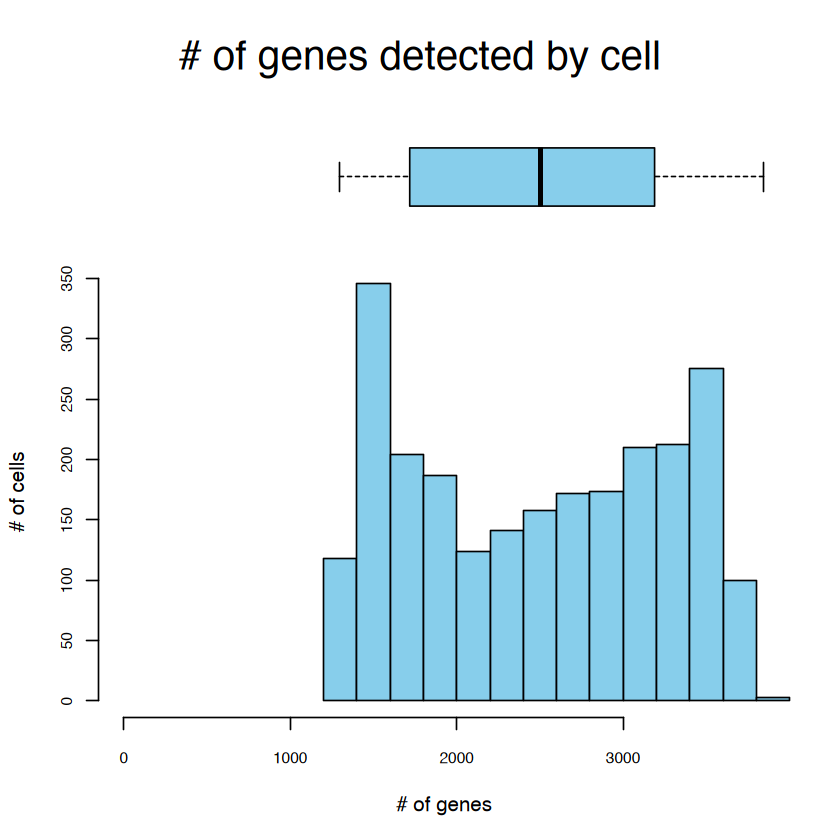

In [320]:
DefaultAssay(Visium) <- 'SCT'
counts <- GetAssayData(object = Visium, slot = "counts")
cell_rankings <- AUCell_buildRankings(counts)

In [503]:
# Immune Signatures Only

Macrophages <- c('AIF1', 'C1QA', 'C1QB', 'C1QC', 'C3AR1', 'CD163', 'CD33', 'DOK2', 'F13A1', 'FGD2', 'FOLR2', 'GPR34', 
                 'LILRB4', 'LYVE1', 'MARCO', 'MPEG1', 'MRC1', 'MS4A4A', 'MS4A4E', 'MS4A6A', 'RNASE6', 'SIGLEC1', 'SYK',
                 'TYROBP', 'VSIG4')

Neutrophils <- c('AZU1','BPI','DEFA3','DEFA4','ELANE')

B_cells <- c('CD19','CD20','IGKC','IGLC1','IGLC2','IGLC3','IGLC4','IGHG1','IGHG2','IGHG3','IGHG4','IGHM','IGHE','JCHAIN',
             'IGHA1','IGHA2')

CD4_T_cells <- c('CD4')

T_reg <- c('FOXP3','IL2RA')

CD8_T_cells <- c('CD8A','CD8B')

NK_cells <- c('NCAM1')

Cytotoxic_cells <- c('GZMA','GZMB','GZMK','GZMH','PRF1','GNLY','NKG7','IFNG','TNF')

Classic_Monocytes <- c('CD14','S100A8', 'CCL8', 'S100A9')

# Non_Classic_Monocytes <- c('L1TD1', 'LYPD2', 'CKB', 'CTTNBP2', 'VMO1', 'PAQR4', 'PCDH12', 'THAP10', 'MRAS', 'GSTA4', 
                           # 'ICAM4', 'PPM1N')

DCs <- c('FLT3')

AUC_data <- rbind(
                  # AUC_Neutrophils,
                  AUC_B_cells, 
                  AUC_CD4_T_cells, AUC_T_reg, 
                  AUC_CD8_T_cells, AUC_NK_cells, 
                  AUC_Cytotoxic_cells,
                  AUC_Classic_Monocytes,
                  # AUC_Non_Classic_Monocytes,
                  AUC_DCs)

rownames(AUC_data) <- c(
                        # 'Neutrophils',
                        'B-cells',
                        'CD4-T-cells','T-reg',
                        'CD8-T-cells','NK-cells',
                        'Cytotoxic-cells',
                        'Classic-Monocytes',
                        # 'Non_Classic_Monocytes',
                        'DCs')

AUC_data

ERROR: Error in parse(text = x, srcfile = src): <text>:49:9: неожиданный ')'
48: 
49: AUC_data)
            ^


In [508]:
AUC_Topic_1 <- AUCell_calcAUC((setDT(data)[cell_type == 1, highly_expressed_genes]), cell_rankings)
AUC_Topic_1 <- getAUC(AUC_Topic_1)

AUC_Topic_2 <- AUCell_calcAUC((setDT(data)[cell_type == 2, highly_expressed_genes]), cell_rankings)
AUC_Topic_2 <- getAUC(AUC_Topic_2)

AUC_Topic_3 <- AUCell_calcAUC((setDT(data)[cell_type == 3, highly_expressed_genes]), cell_rankings)
AUC_Topic_3 <- getAUC(AUC_Topic_3)

AUC_Topic_4 <- AUCell_calcAUC((setDT(data)[cell_type == 4, highly_expressed_genes]), cell_rankings)
AUC_Topic_4 <- getAUC(AUC_Topic_4)

AUC_Topic_5 <- AUCell_calcAUC((setDT(data)[cell_type == 5, highly_expressed_genes]), cell_rankings)
AUC_Topic_5 <- getAUC(AUC_Topic_5)

AUC_Topic_6 <- AUCell_calcAUC((setDT(data)[cell_type == 6, highly_expressed_genes]), cell_rankings)
AUC_Topic_6 <- getAUC(AUC_Topic_6)

AUC_Topic_7 <- AUCell_calcAUC((setDT(data)[cell_type == 7, highly_expressed_genes]), cell_rankings)
AUC_Topic_7 <- getAUC(AUC_Topic_7)

AUC_Topic_8 <- AUCell_calcAUC((setDT(data)[cell_type == 8, highly_expressed_genes]), cell_rankings)
AUC_Topic_8 <- getAUC(AUC_Topic_8)

AUC_Macrophages <- AUCell_calcAUC(Macrophages, cell_rankings)
AUC_Macrophages <- getAUC(AUC_Macrophages)

# AUC_Neutrophils <- AUCell_calcAUC(Neutrophils, cell_rankings)
# AUC_Neutrophils <- getAUC(AUC_Neutrophils)

AUC_B_cells <- AUCell_calcAUC(B_cells, cell_rankings)
AUC_B_cells <- getAUC(AUC_B_cells)

AUC_CD4_T_cells <- AUCell_calcAUC(CD4_T_cells, cell_rankings)
AUC_CD4_T_cells <- getAUC(AUC_CD4_T_cells)

AUC_T_reg <- AUCell_calcAUC(T_reg, cell_rankings)
AUC_T_reg <- getAUC(AUC_T_reg)

AUC_CD8_T_cells <- AUCell_calcAUC(CD8_T_cells, cell_rankings)
AUC_CD8_T_cells <- getAUC(AUC_CD8_T_cells)

AUC_NK_cells <- AUCell_calcAUC(NK_cells, cell_rankings)
AUC_NK_cells <- getAUC(AUC_NK_cells)

AUC_Cytotoxic_cells <- AUCell_calcAUC(Cytotoxic_cells, cell_rankings)
AUC_Cytotoxic_cells <- getAUC(AUC_Cytotoxic_cells)

AUC_Classic_Monocytes <- AUCell_calcAUC(Classic_Monocytes, cell_rankings)
AUC_Classic_Monocytes <- getAUC(AUC_Classic_Monocytes)

# AUC_Non_Classic_Monocytes <- AUCell_calcAUC(AUC_Non_Classic_Monocytes, cell_rankings)
# AUC_Non_Classic_Monocytes <- getAUC(AUC_Non_Classic_Monocytes)

AUC_DCs <- AUCell_calcAUC(DCs, cell_rankings)
AUC_DCs <- getAUC(AUC_DCs)

Genes in the gene sets NOT available in the dataset: 
	geneSet: 	1 (4% of 25)

Genes in the gene sets NOT available in the dataset: 
	geneSet: 	5 (31% of 16)



In [527]:
AUC_data <- rbind(AUC_Topic_1, AUC_Topic_2,
                  AUC_Topic_3, AUC_Topic_4,
                  AUC_Topic_5, AUC_Topic_6,
                  AUC_Topic_7, AUC_Topic_8,
                  AUC_Macrophages,
                  # AUC_Neutrophils,
                  AUC_B_cells, 
                  AUC_CD4_T_cells, AUC_T_reg, 
                  AUC_CD8_T_cells, AUC_NK_cells, 
                  AUC_Cytotoxic_cells,
                  AUC_Classic_Monocytes,
                  # AUC_Non_Classic_Monocytes,
                  AUC_DCs)

rownames(AUC_data) <- c('Topic 1','Topic 2',
                        'Topic 3','Topic 4',
                        'Topic 5','Topic 6',
                        'Topic 7','Topic 8',
                        'Macrophages',
                        # 'Neutrophils',
                        'B-cells',
                        'CD4-T-cells','T-reg',
                        'CD8-T-cells','NK-cells',
                        'Cytotoxic-cells',
                        'Classic-Monocytes',
                        # 'Non_Classic_Monocytes',
                        'DCs')

AUC_data

AAACACCAATAACTGC-1 AAACAGGGTCTATATT-1 AAACATTTCCCGGATT-1
Topic 1           0.28690909         0.37185455         0.2439272727      
Topic 2           0.41919102         0.45585353         0.4282341411      
Topic 3           0.32208163         0.39844898         0.4170612245      
Topic 4           0.47178581         0.52978528         0.2649908353      
Topic 5           0.22496838         0.32482139         0.2295491061      
Topic 6           0.16023206         0.23470860         0.1901522514      
Topic 7           0.31653423         0.35920013         0.2962034982      
Topic 8           0.24813801         0.34167250         0.3200500775      
Macrophages       0.12443893         0.07199386         0.0341365462      
B-cells           0.07213994         0.00000000         0.1306179775      
CD4-T-cells       0.00000000         0.00000000         0.0000000000      
T-reg             0.00000000         0.00000000         0.0000000000      
CD8-T-cells       0.00000000         0.00000000         0.0000000000      
NK-cells          0.00000000         0.00000000         0.0000000000      
Cytotoxic-cells   0.00000000         0.00000000         0.0001558361      
Classic-Monocytes 0.06114605         0.38015374         0.0000000000      
DCs               0.00000000         0.00000000         0.0000000000      
                  AAACCGGGTAGGTACC-1 AAACCGTTCGTCCAGG-1 AAACCTAAGCAGCCGG-1
Topic 1           0.34664242         0.29330909         0.470957576       
Topic 2           0.45171062         0.49518888         0.735343906       
Topic 3           0.42224490         0.38289796         0.472653061       
Topic 4           0.28875360         0.43700358         0.168805097       
Topic 5           0.30297747         0.28390251         0.412641438       
Topic 6           0.22973172         0.22843596         0.325028713       
Topic 7           0.32784499         0.29868518         0.682869210       
Topic 8           0.31440575         0.28174932         0.569397585       
Macrophages       0.08959367         0.03130168         0.042404914       
B-cells           0.00000000         0.04290092         0.077630235       
CD4-T-cells       0.00000000         0.00000000         0.000000000       
T-reg             0.00000000         0.00000000         0.001395673       
CD8-T-cells       0.00000000         0.00000000         0.000000000       
NK-cells          0.00000000         0.00000000         0.000000000       
Cytotoxic-cells   0.00000000         0.08804737         0.000000000       
Classic-Monocytes 0.20020964         0.26659679         0.000000000       
DCs               0.00000000         0.00000000         0.000000000       
                  AAACGAGACGGTTGAT-1 AAACGGGCGTACGGGT-1 AAACGGTTGCGAACTG-1
Topic 1           0.34487273         0.506472727        0.26623030        
Topic 2           0.49251604         0.559248040        0.39259622        
Topic 3           0.48865306         0.428408163        0.37791837        
Topic 4           0.34738588         0.165357423        0.20229990        
Topic 5           0.40054012         0.337538030        0.19806516        
Topic 6           0.31130547         0.256412522        0.16034985        
Topic 7           0.33803422         0.625957477        0.29121626        
Topic 8           0.32312687         0.488891718        0.32694634        
Macrophages       0.02510040         0.005669738        0.13512875        
B-cells           0.08248212         0.000000000        0.08924923        
CD4-T-cells       0.00000000         0.000000000        0.00000000        
T-reg             0.00000000         0.000000000        0.00000000        
CD8-T-cells       0.00000000         0.000000000        0.00000000        
NK-cells          0.36820084         0.000000000        0.00000000        
Cytotoxic-cells   0.00000000         0.000000000        0.01947951        
Classic-Monocytes 0.48742138         0.122292103        0.01677149        
DCs               0.00000000         0.0000

In [529]:
Visium[['AUC']] <- CreateAssayObject(data = AUC_data)
DefaultAssay(Visium) <- 'AUC'
Visium

Warning message:
“Different cells and/or features from existing assay AUC”


An object of class Seurat 
32301 features across 2423 samples within 3 assays 
Active assay: AUC (17 features, 0 variable features)
 1 layer present: data
 2 other assays present: Spatial, SCT
 3 dimensional reductions calculated: pca, umap, aucpca
 1 image present: slice1

## PCA, UMAP, and Clustering

In [511]:
DefaultAssay(Visium) <- 'AUC'

VariableFeatures(Visium) <- rownames(Visium[["AUC"]])

Visium <- ScaleData(Visium)

# Calculate PCs
Visium <- RunPCA(Visium,
                        reduction.name = "aucpca",
                        reduction.key = "AUCPC_",npcs = 40)

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Requested number is larger than the number of available items (16). Setting to 16.”
Warning message:
“Requested number is larger than the number of available items (16). Setting to 16.”
Warning message:
“Requested number is larger than the number of available items (16). Setting to 16.”
Warning message:
“Requested number is larger than the number of available items (16). Setting to 16.”
Warning message:
“Requested number is larger than the number of available items (16). Setting to 16.”
AUCPC_ 1 
Positive:  Topic 8, Topic 1, Topic 7, Topic 2, Topic 5, Topic 3, Topic 6, Classic-Monocytes 
Negative:  Topic 4, Cytotoxic-cells, NK-cells, CD4-T-cells, CD8-T-cells, DCs, T-reg, B-cells 
AUCPC_ 2 
Positive:  Topic 6, Topic 5, Topic 1, Topic 4, Cytotoxic-cells, Classic-Monocytes, Topic 7,

Warning message in ElbowPlot(harmonized_seurat, ndims = 40, reduction = "aucpca"):
“The object only has information for 15 reductions”


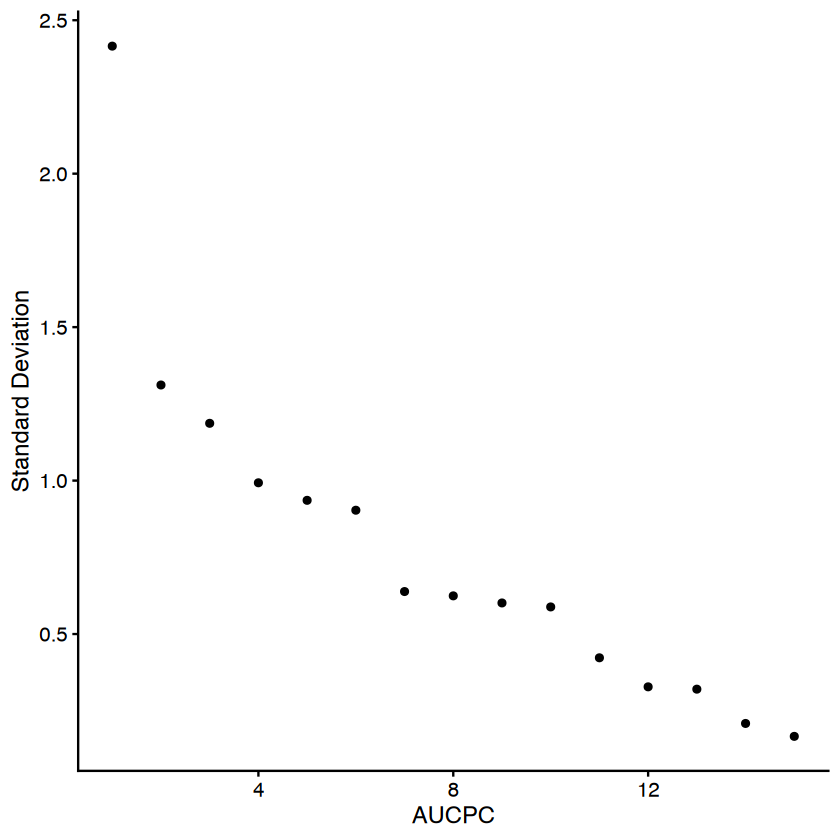

In [512]:
ElbowPlot(Visium, ndims = 40, reduction = "aucpca")

In [513]:
dims = 15

Visium <- FindNeighbors(Visium, reduction = "aucpca", dims = 1:dims)
Visium <- FindClusters(Visium, verbose = TRUE)
Visium <- RunUMAP(Visium, 
                             reduction = "aucpca",
                             dims = 1:dims)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2423
Number of edges: 75027

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8184
Number of communities: 11
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”
14:51:32 UMAP embedding parameters a = 0.9922 b = 1.112

В кеше найдено больше одного класса "dist"; использую первый, из пространства имен 'spam'

Также определен в ‘BiocGenerics’

14:51:32 Read 2423 rows and found 15 numeric columns

14:51:32 Using Annoy for neighbor search, n_neighbors = 30

В кеше найдено больше одного класса "dist"; использую первый, из пространства имен 'spam'

Также определен в ‘BiocGenerics’

14:51:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


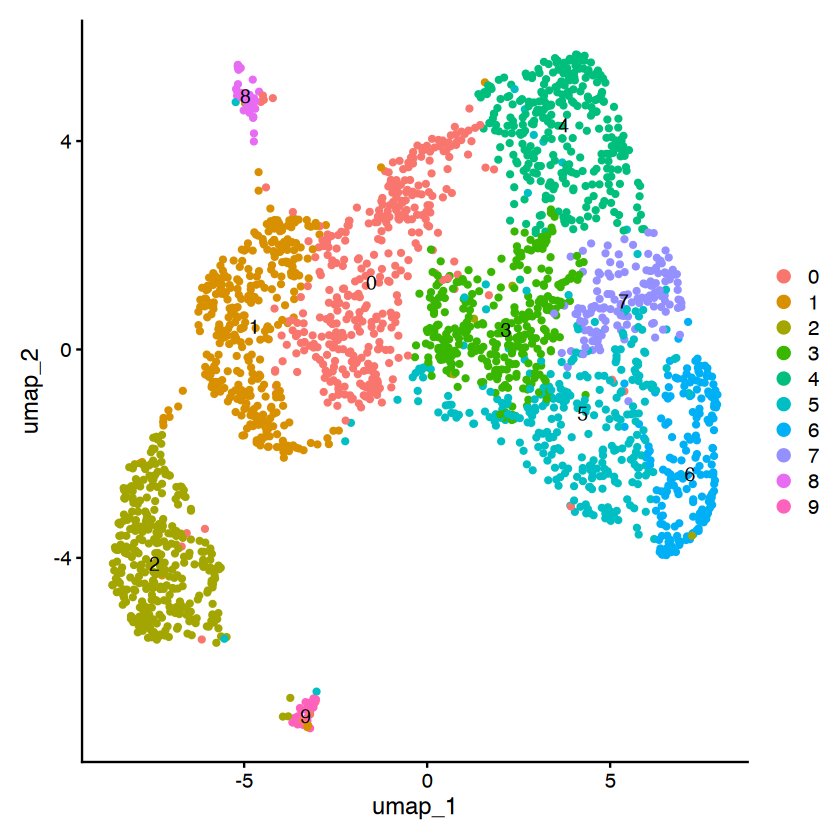

In [516]:
Visium <- FindClusters(Visium,
                                  resolution = 0.7,
                                  verbose = FALSE)

DimPlot(Visium, reduction = "umap",
        pt.size = 1.25,label = TRUE)

ggsave(
  "AUC UMAP.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1, 
#   1 plot == 10 cm in each dimention
  width = 17,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


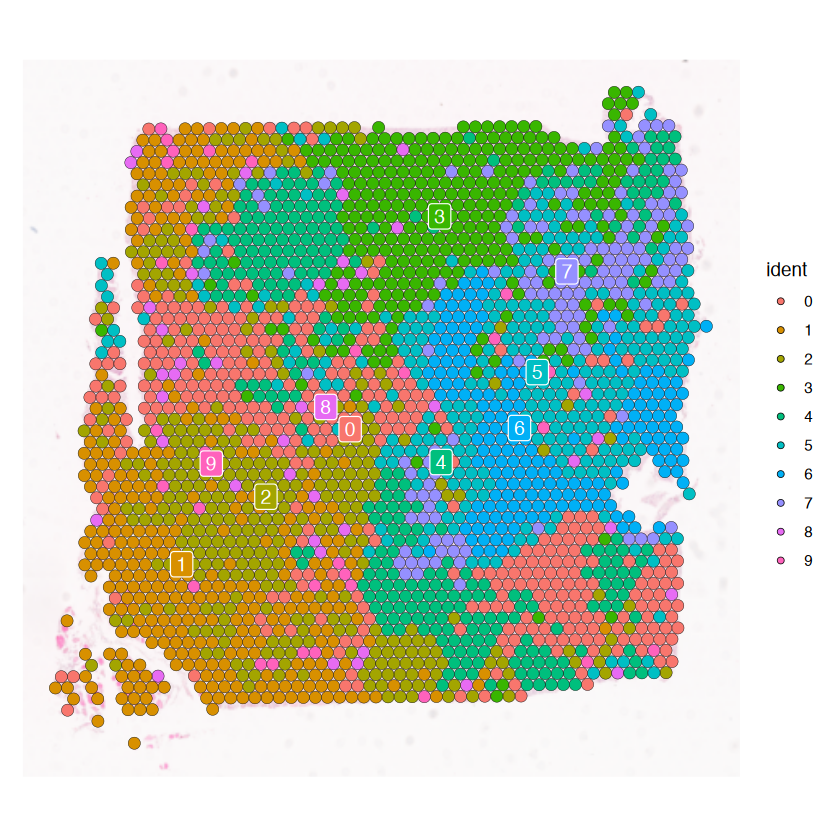

In [517]:
SpatialDimPlot(Visium, label = TRUE, label.size = 4)
ggsave(
  "Spatial AUC.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1, 
#   1 plot == 10 cm in each dimention
  width = 19,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

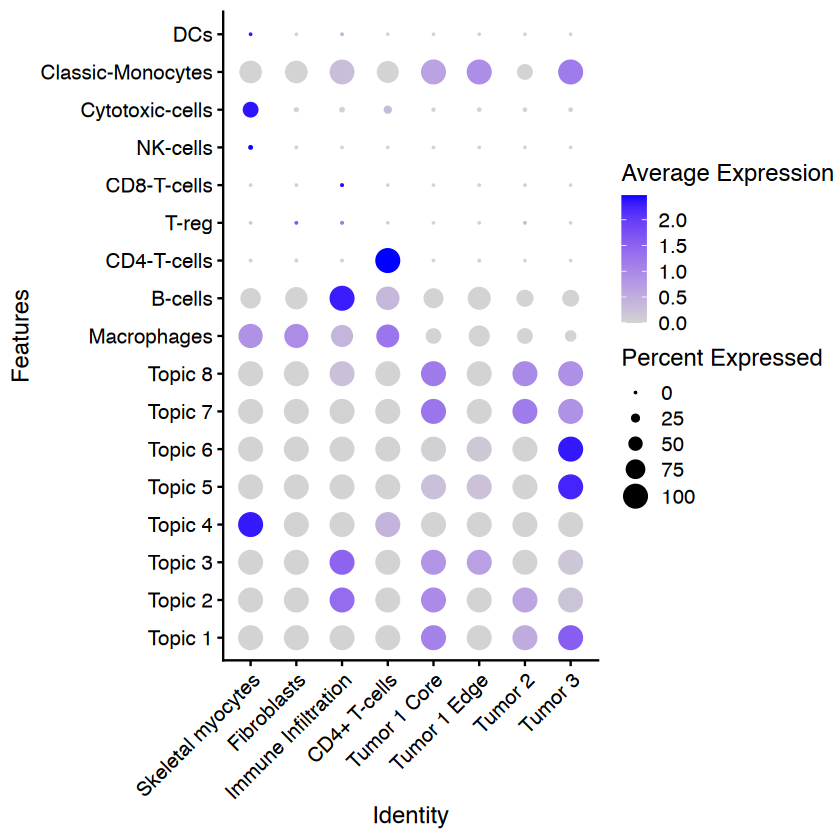

In [531]:
features = c('Topic 1','Topic 2',
                        'Topic 3','Topic 4',
                        'Topic 5','Topic 6',
                        'Topic 7','Topic 8',
                        'Macrophages',
                        # 'Neutrophils',
                        'B-cells',
                        'CD4-T-cells','T-reg',
                        'CD8-T-cells','NK-cells',
                        'Cytotoxic-cells',
                        'Classic-Monocytes',
                        # 'Non_Classic_Monocytes',
                        'DCs')

DotPlot(Visium, 
         col.min = 0, 
        features = features) + RotatedAxis() + coord_flip() 
# + scale_colour_viridis()

# Save the last plot as a pdf

ggsave(
  "AUC Dot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 30 ,
  height = 17,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

## Re-order and re-name clusters 

In [521]:
levels(Visium) <- c('1','2','9',
                               '0',
                               '3',
                               '8',
                               '7',
                               '5', 
                               '4',
                               '6'
                              )

new.cluster.ids <- c('Skeletal myocytes','Skeletal myocytes','Skeletal myocytes',
                     'Fibroblasts',
                     'Immune Infiltration',
                     'CD4+ T-cells',
                     'Tumor 1 Core',
                     'Tumor 1 Edge', 
                     'Tumor 2',
                     'Tumor 3'
                     )

names(new.cluster.ids) <- levels(Visium)
Visium <- RenameIdents(Visium, new.cluster.ids)

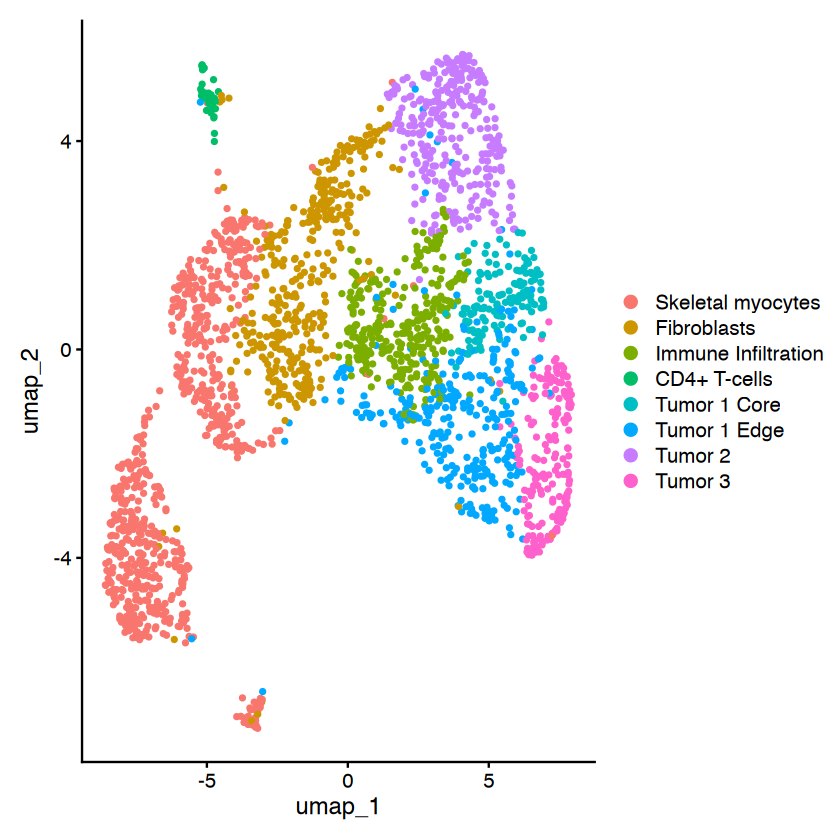

In [522]:
DimPlot(Visium, reduction = "umap",
        pt.size = 1,label = FALSE)

ggsave(
  "AUC Clusters UMAP.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1, 
#   1 plot == 10 cm in each dimention
  width = 20.5,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

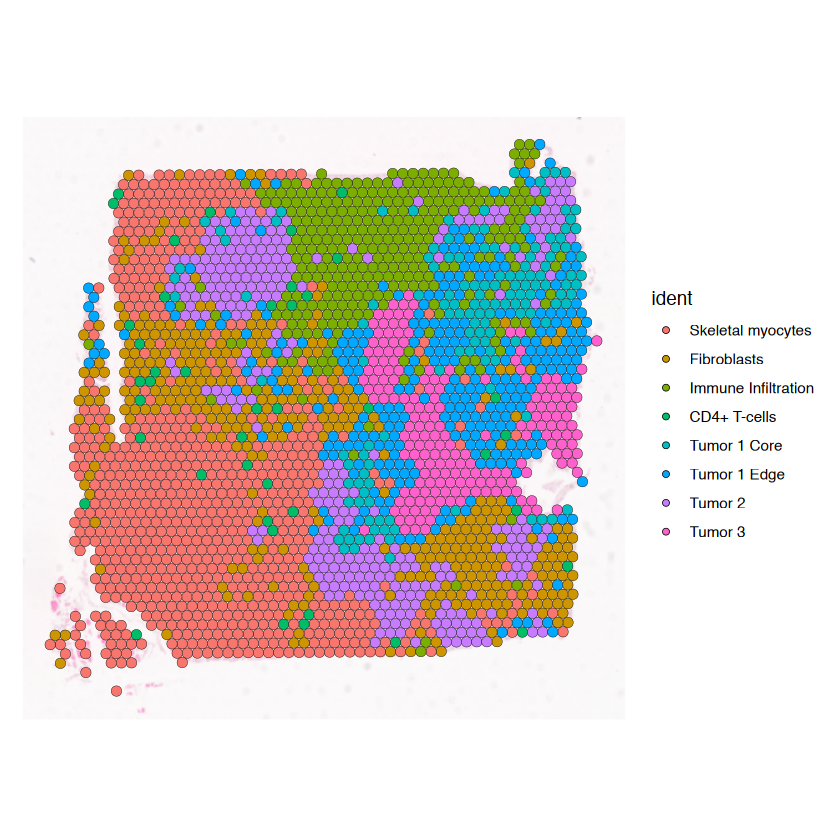

In [523]:
SpatialDimPlot(Visium, label = FALSE, label.size = 4)
ggsave(
  "Spatial AUC.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1, 
#   1 plot == 10 cm in each dimention
  width = 19,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

In [524]:
saveRDS(Visium, file = "Seurat_Spatial.rds")

In [431]:
Visium <- readRDS("Seurat_Spatial.rds")

## DGE

In [545]:
DefaultAssay(Visium) <- 'SCT'

cluster <- FindMarkers(Visium, 
                       ident.1 = "Tumor 1 Core", 
                       ident.2 = "Tumor 1 Edge",
                       only.pos = FALSE, 
                       logfc.threshold = 1.,
                       min.pct = 0.5, recorrect_umi=FALSE)
cluster <- cluster[order(cluster$avg_log2FC,decreasing=FALSE),]
head(cluster, 10)
write.csv(cluster, "Core vs Edge DGE.csv")

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
MYLPF  2.193168e-15 -2.880337  0.130 0.513 3.145222e-11
TNNI1  2.166918e-11 -2.592066  0.192 0.503 3.107577e-07
ACTC1  1.975560e-16 -2.054708  0.219 0.626 2.833150e-12
CXCL12 4.030085e-19 -1.879527  0.253 0.705 5.779545e-15
C3     1.213524e-16 -1.874705  0.329 0.705 1.740315e-12
RGS16  8.111204e-18 -1.720807  0.260 0.689 1.163228e-13
TNNT3  3.501992e-15 -1.633033  0.274 0.672 5.022207e-11
TTN    5.685286e-13 -1.620214  0.144 0.526 8.153268e-09
PI3    1.152983e-11 -1.594144  0.466 0.725 1.653493e-07
AQP1   7.041814e-12 -1.590459  0.240 0.583 1.009867e-07

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


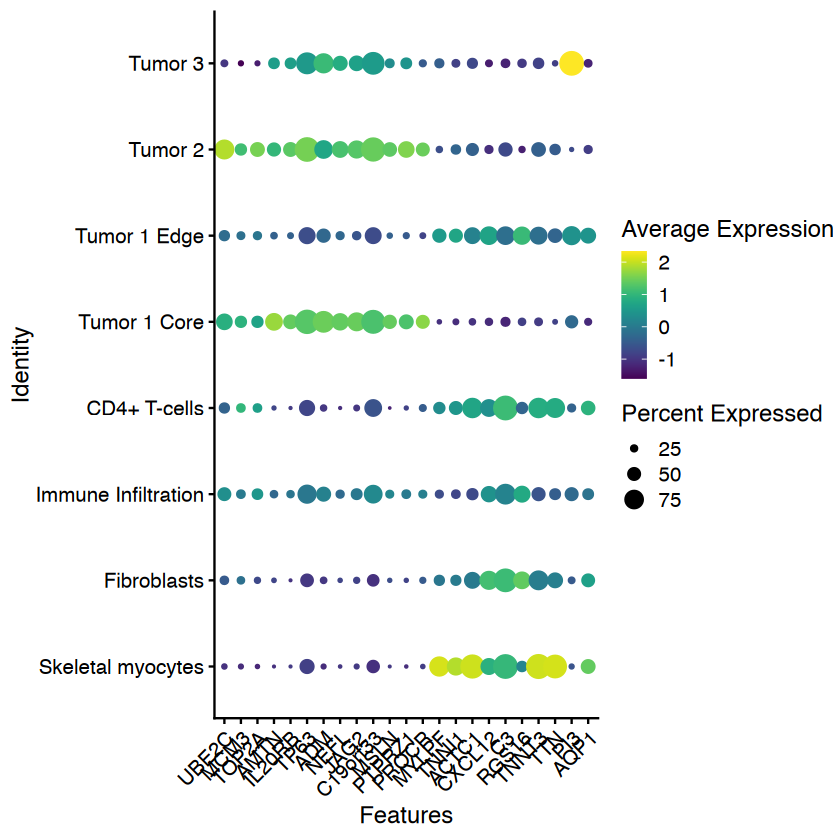

In [544]:
library(viridis)
features = c('UBE2C','MCM3','TOP2A',
             'AMTN','IL20RB','TP63',
             'ADM','NEFL','JAG2','C19orf33','MSLN','PTPRZ1','PROCR',
             'MYLPF','TNNI1','ACTC1','CXCL12','C3','RGS16','TNNT3','TTN','PI3','AQP1' )

DotPlot(Visium, 
         # col.min = 0,  
        features = features) + RotatedAxis()  + scale_colour_viridis()
#  + coord_flip()

# Save the last plot as a pdf

ggsave(
  "AUC DGE Dot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 30 ,
  height = 16,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

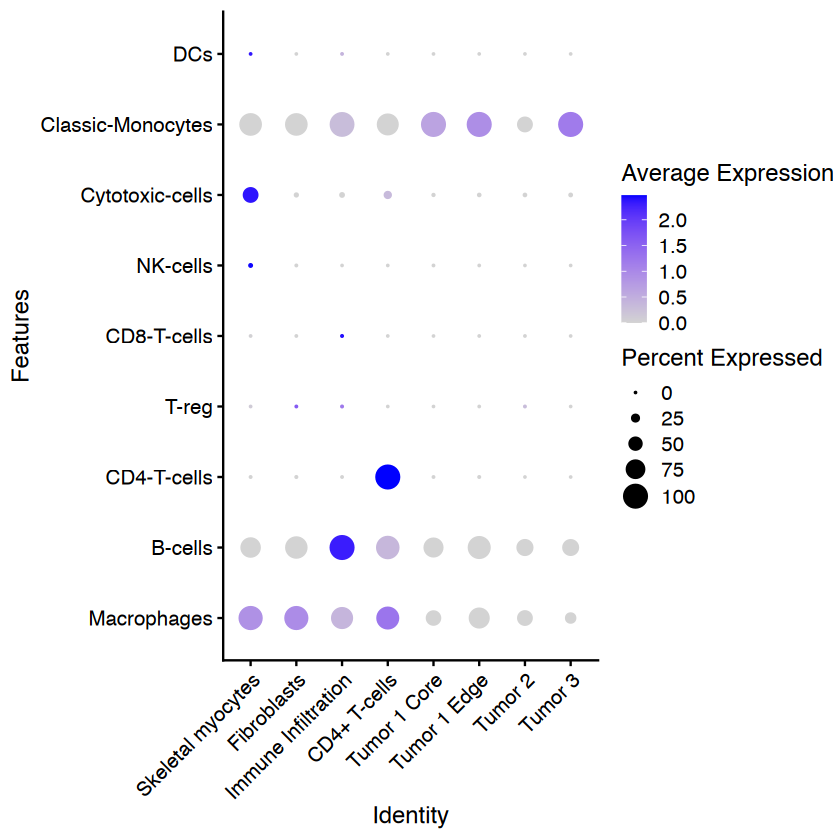

In [533]:
DefaultAssay(Visium) <- 'AUC'

features = c('Macrophages',
             # 'Neutrophils',
             'B-cells','CD4-T-cells','T-reg',
             'CD8-T-cells', 'NK-cells',
             'Cytotoxic-cells',
             'Classic-Monocytes',
             'DCs')

DotPlot(Visium, 
         col.min = 0, 
        features = features) + RotatedAxis() + coord_flip() 
# + scale_colour_viridis()

# Save the last plot as a pdf

ggsave(
  "AUC QC Dot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 30 ,
  height = 16,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)